# Notebook 01 — Exploration des data BAAC

**Objectif** : Explorer les 4 tables BAAC (caractéristiques, lieux, usagers, véhicules) sur les data 2021-2024 pour comprendre la structure, identifier les variables pertinentes et définir la cible de prédiction.

**Input** : Fichiers CSV bruts BAAC par année (2021-2024)
**Output** : Compréhension des data, choix de la cible `grave`
**Notebook suivant** : `02a_preparation_complete.ipynb`

---

## 1. Configuration et imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
from pathlib import Path

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')

# Chemin des data (depuis notebooks/01_exploration/)
DATA_DIR = Path("../../data")

print("Configuration chargée")

Configuration chargée


---

## 2. Chargement des data multi-années

### Particularités des fichiers par année

Les fichiers BAAC ont des noms et structures légèrement différents selon les années :

| Année | Fichier caractéristiques | Clé primaire |
|-------|--------------------------|---------------|
| 2021  | carcteristiques-2021.csv (typo) | Num_Acc |
| 2022  | carcteristiques-2022.csv (typo) | Accident_Id  |
| 2023  | caract-2023.csv | Num_Acc |
| 2024  | caract-2024.csv | Num_Acc |

Point d'attention : En 2022, la clé est Accident_Id au lieu de Num_Acc. Il faudra la renommer.

In [2]:
# noms des fichiers par année (y a des typos dans les noms originaux)
ANNEES = [2021, 2022, 2023, 2024]

def get_filenames(annee):
    if annee <= 2022:
        prefix = 'carcteristiques'
    else:
        prefix = 'caract'
    return {
        'caract': f'{prefix}-{annee}.csv',
        'lieux': f'lieux-{annee}.csv',
        'usagers': f'usagers-{annee}.csv',
        'vehicules': f'vehicules-{annee}.csv'
    }

print(f"Années à charger : {ANNEES}")

Années à charger : [2021, 2022, 2023, 2024]


In [3]:
def charger_donnees_annee(annee):
    # charge les 4 tables pour une année
    files = get_filenames(annee)
    data = {}
    
    for table_name, filename in files.items():
        filepath = DATA_DIR / str(annee) / filename
        
        df = pd.read_csv(filepath, sep=';', low_memory=False)
        
        # en 2022 la clé s'appelle Accident_Id au lieu de Num_Acc
        if 'Accident_Id' in df.columns:
            df = df.rename(columns={'Accident_Id': 'Num_Acc'})
        
        df['annee'] = annee
        data[table_name] = df
    
    return data

# Charger toutes les années
donnees_par_annee = {}
for annee in ANNEES:
    print(f"Chargement {annee}...", end=" ")
    donnees_par_annee[annee] = charger_donnees_annee(annee)
    print(f"OK - {donnees_par_annee[annee]['caract'].shape[0]} accidents")

total = sum(d['caract'].shape[0] for d in donnees_par_annee.values())
print(f"\nTotal : {total} accidents")

# Concaténer toutes les années pour l'exploration
all_caract = pd.concat([d['caract'] for d in donnees_par_annee.values()], ignore_index=True)
all_lieux = pd.concat([d['lieux'] for d in donnees_par_annee.values()], ignore_index=True)
all_usagers = pd.concat([d['usagers'] for d in donnees_par_annee.values()], ignore_index=True)
all_vehicules = pd.concat([d['vehicules'] for d in donnees_par_annee.values()], ignore_index=True)

print("\nDatasets concaténés (4 années) :")
print(f"  CARACT    : {len(all_caract)} accidents")
print(f"  LIEUX     : {len(all_lieux)} lignes")
print(f"  USAGERS   : {len(all_usagers)} usagers")
print(f"  VEHICULES : {len(all_vehicules)} véhicules")

Chargement 2021... OK - 56518 accidents
Chargement 2022... OK - 55302 accidents
Chargement 2023... OK - 54822 accidents
Chargement 2024... OK - 54402 accidents

Total : 221044 accidents

Datasets concaténés (4 années) :
  CARACT    : 221044 accidents
  LIEUX     : 252928 lignes
  USAGERS   : 506886 usagers
  VEHICULES : 378071 véhicules


---

## 3. Vue d'ensemble des data

### 3.1 Volume par année et par table

In [4]:
# tableau récapitulatif par année
stats_annees = []

for annee in ANNEES:
    data = donnees_par_annee[annee]
    stats_annees.append({
        'Année': annee,
        'Accidents': data['caract'].shape[0],
        'Lieux': data['lieux'].shape[0],
        'Usagers': data['usagers'].shape[0],
        'Véhicules': data['vehicules'].shape[0]
    })

df_stats = pd.DataFrame(stats_annees)

# ajouter les totaux
totaux = df_stats.sum(numeric_only=True)
totaux['Année'] = 'TOTAL'
df_stats = pd.concat([df_stats, pd.DataFrame([totaux])], ignore_index=True)

print("Volume de data par année et par table")
print("---")
print(df_stats.to_string(index=False))

Volume de données par année et par table
---
Année  Accidents  Lieux  Usagers  Véhicules
 2021      56518  56518   129248      97315
 2022      55302  55302   126662      94493
 2023      54822  70860   125789      93585
 2024      54402  70248   125187      92678
TOTAL     221044 252928   506886     378071


/var/folders/5q/1z0_7_dd4559pfbhnn6y1dj80000gp/T/ipykernel_60616/3307190367.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TOTAL' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



### Observation importante : Anomalie table LIEUX

Le tableau ci-dessus révèle une anomalie dans la table LIEUX :
- 2021-2022 : ~56k lignes (= nombre d'accidents, 1 ligne par accident)
- 2023-2024 : ~70k lignes (> nombre d'accidents)

Cette différence indique un changement de format à partir de 2023 : les intersections sont désormais enregistrées avec plusieurs lignes par accident. Cela ne concerne que 2023-2024 (~29% des accidents de ces années).

Impact : Il faudra dédupliquer la table LIEUX en gardant une seule ligne par accident (celle avec la VMA la plus élevée).

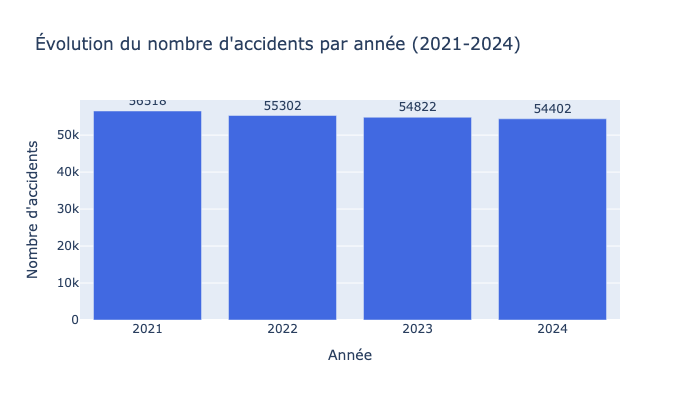

In [5]:
# evolution du nombre d'accidents par année
df_plot = df_stats[df_stats['Année'] != 'TOTAL'].copy()
df_plot['Année'] = df_plot['Année'].astype(str)

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=df_plot['Année'],
        y=df_plot['Accidents'],
        name='Accidents',
        marker_color='royalblue',
        text=df_plot['Accidents'],
        textposition='outside'
    )
)

fig.update_layout(
    title_text="Évolution du nombre d'accidents par année (2021-2024)",
    xaxis_title="Année",
    yaxis_title="Nombre d'accidents",
    height=400
)

fig.show()

### Observations

- ~53-54k accidents par an, relativement stable sur 4 ans
- En moyenne ~2.3 usagers par accident et ~1.7 véhicules par accident
- Le nombre de lieux est supérieur au nombre d'accidents → certains accidents ont plusieurs lieux (intersections)

---

## 4. Structure des tables

Les data BAAC sont organisées en 4 tables relationnelles liées par Num_Acc :

```
CARACT (1 ligne/accident)
    │
    ├── LIEUX (1+ lignes/accident) - caractéristiques de la route
    │
    ├── VEHICULES (1+ lignes/accident) - véhicules impliqués
    │
    └── USAGERS (1+ lignes/accident) - personnes impliquées + GRAVITÉ
```

In [6]:
# vérifier la structure de toutes les années
print("STRUCTURE DES TABLES PAR ANNÉE")
print("---")

for table_name in ['caract', 'lieux', 'usagers', 'vehicules']:
    print(f"\n{table_name.upper()}")
    for annee in ANNEES:
        df = donnees_par_annee[annee][table_name]
        cols = [c for c in df.columns if c != 'annee']
        print(f"  {annee} : {df.shape[0]} lignes x {len(cols)} colonnes")
    
    # colonnes de la dernière année comme référence
    ref_cols = [c for c in donnees_par_annee[2024][table_name].columns if c != 'annee']
    print(f"  Colonnes : {ref_cols}")

STRUCTURE DES TABLES PAR ANNÉE
---

CARACT
  2021 : 56518 lignes x 15 colonnes
  2022 : 55302 lignes x 15 colonnes
  2023 : 54822 lignes x 15 colonnes
  2024 : 54402 lignes x 15 colonnes
  Colonnes : ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long']

LIEUX
  2021 : 56518 lignes x 18 colonnes
  2022 : 55302 lignes x 18 colonnes
  2023 : 70860 lignes x 18 colonnes
  2024 : 70248 lignes x 18 colonnes
  Colonnes : ['Num_Acc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma']

USAGERS
  2021 : 129248 lignes x 16 colonnes
  2022 : 126662 lignes x 16 colonnes
  2023 : 125789 lignes x 16 colonnes
  2024 : 125187 lignes x 16 colonnes
  Colonnes : ['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp']

VEHICULES
  2021 : 97315 lignes x 11 colonnes
  20

### 4.1 Table CARACT (Caractéristiques de l'accident)

Granularité : 1 ligne par accident

| Colonne | Description | Type |
|---------|-------------|------|
| Num_Acc | Identifiant unique de l'accident | Clé primaire |
| jour, mois, an | Date de l'accident | Temporel |
| hrmn | Heure et minute (format HHMM) | Temporel |
| lum | Conditions de luminosité | Catégoriel |
| agg | En/hors agglomération | Binaire |
| int | Type d'intersection | Catégoriel |
| atm | Conditions atmosphériques | Catégoriel |
| col | Type de collision | Catégoriel |
| lat, long | Coordata GPS | Numérique |

In [7]:
# explorer la table CARACT
print(f"Table CARACT : {len(all_caract)} lignes sur 4 ans")
print("\nÉchantillon :")
display(all_caract.head(3))

print("\nTypes de data :")
print(all_caract.dtypes)

Table CARACT : 221044 lignes sur 4 ans

Échantillon :


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,annee
0,202100000001,30,11,2021,07:32,2,30,30319,1,1,1,1,CD 981,"44,0389580000","4,3480220000",2021
1,202100000002,25,9,2021,14:20,1,51,51544,1,3,1,3,Aire de repos croisement D20E9 après sortie D977,"49,2421290000","4,5545460000",2021
2,202100000003,15,7,2021,07:55,1,85,85048,2,1,7,6,15 rue François Nicolas,"46,9219500000","-0,9644600000",2021



Types de données :
Num_Acc     int64
jour        int64
mois        int64
an          int64
hrmn       object
lum         int64
dep        object
com        object
agg         int64
int         int64
atm         int64
col         int64
adr        object
lat        object
long       object
annee       int64
dtype: object


### 4.2 Table LIEUX (Caractéristiques de la route)

Granularité : 1+ lignes par accident (intersections)

| Colonne | Description |
|---------|-------------|
| catr | Catégorie de route (autoroute, nationale, départementale...) |
| circ | Régime de circulation (sens unique, bidirectionnel...) |
| nbv | Nombre de voies |
| vma | Vitesse maximale autorisée |
| prof | Profil de la route (plat, pente...) |
| plan | Tracé (ligne droite, courbe...) |
| surf | État de la surface |
| larrout | Largeur de la route |

In [8]:
# analyser le problème des lieux multiples
lieux_par_accident = all_lieux.groupby('Num_Acc').size()
distribution_lieux = lieux_par_accident.value_counts().sort_index()

print(f"Nombre de lignes LIEUX par accident ({len(all_lieux)} lignes, 4 années) :")
print(distribution_lieux)

pct_multi = (lieux_par_accident > 1).sum() / len(lieux_par_accident) * 100
print(f"\n{pct_multi:.1f}% des accidents ont plusieurs lieux (intersections)")

# détail par année
print("\nDétail par année :")
for annee in ANNEES:
    lieux_annee = donnees_par_annee[annee]['lieux']
    lieux_par_acc = lieux_annee.groupby('Num_Acc').size()
    pct = (lieux_par_acc > 1).sum() / len(lieux_par_acc) * 100
    print(f"  {annee} : {pct:.1f}% des accidents ont plusieurs lieux")

Nombre de lignes LIEUX par accident (252928 lignes, 4 années) :
1    189529
2     31178
3       307
4        28
5         2
Name: count, dtype: int64

14.3% des accidents ont plusieurs lieux (intersections)

Détail par année :
  2021 : 0.0% des accidents ont plusieurs lieux
  2022 : 0.0% des accidents ont plusieurs lieux
  2023 : 28.9% des accidents ont plusieurs lieux
  2024 : 28.8% des accidents ont plusieurs lieux


### Décision technique : Gestion des lieux multiples

14.3% des accidents ont plusieurs entrées dans la table LIEUX, mais ce phénomène est limité à 2023-2024 (~29% de ces années, 0% en 2021-2022). Il s'agit d'un changement de format BAAC pour les accidents aux intersections.

Stratégie retenue : Garder uniquement la ligne avec la VMA la plus élevée par accident.

Justification : Pour un accident à une intersection, les caractéristiques de la voie principale (plus grande VMA) sont plus pertinentes pour la gravité.

### 4.3 Table USAGERS (Personnes impliquées + Gravité)

Granularité : 1 ligne par personne impliquée

IMPORTANT : Cette table contient la variable cible grav !

| Colonne | Description |
|---------|-------------|
| grav | Gravité des blessures (1=indemne, 2=tué, 3=hospitalisé, 4=blessé léger) |
| catu | Catégorie d'usager (conducteur, passager, piéton) |
| sexe | Sexe |
| an_nais | Année de naissance |
| trajet | Motif du trajet |
| secu1-3 | Équipements de sécurité |

In [9]:
# explorer la table USAGERS
print(f"Table USAGERS : {len(all_usagers)} lignes sur 4 ans")
print("\nÉchantillon :")
display(all_usagers[['Num_Acc', 'catu', 'grav', 'sexe', 'an_nais']].head(5))

print(f"\nAccidents uniques     : {all_usagers['Num_Acc'].nunique()}")
print(f"Usagers par accident  : {len(all_usagers) / all_usagers['Num_Acc'].nunique():.2f}")

Table USAGERS : 506886 lignes sur 4 ans

Échantillon :


,Num_Acc,catu,grav,sexe,an_nais
0,202100000001,1,3,1,2000.0
1,202100000001,1,1,1,1978.0
2,202100000002,1,4,1,1983.0
3,202100000002,1,3,1,1993.0
4,202100000003,1,1,1,1995.0



Accidents uniques     : 221044
Usagers par accident  : 2.29


### 4.4 Table VEHICULES

Granularité : 1 ligne par véhicule impliqué

| Colonne | Description |
|---------|-------------|
| catv | Catégorie de véhicule (voiture, moto, vélo, poids lourd...) |
| obs | Obstacle fixe heurté |
| obsm | Obstacle mobile heurté |
| choc | Point de choc initial |
| manv | Manœuvre avant l'accident |

### Observation : Distribution des véhicules

La distribution des catégories de véhicules (2021-2024) :

| Rang | Catégorie | Implications pour la gravité |
|------|-----------|------------------------------|
| 1 | Voiture (~58%) | Catégorie dominante, référence |
| 2 | Moto > 125cm3 (~8%) | Usagers vulnérables, risque élevé |
| 3 | VU ≤ 3.5T (~8%) | Véhicules utilitaires |
| 4 | Vélo (~5%) | Usagers très vulnérables |
| 5 | Cyclomoteur (~3%) | Usagers vulnérables |

À explorer : Créer une feature has_vulnerable (moto, vélo, EDP) car ces usagers ont un risque de gravité plus élevé.

In [10]:
# explorer la table VEHICULES
print(f"Distribution des catégories de véhicules ({len(all_vehicules)} véhicules, 4 années) :")
print(all_vehicules['catv'].value_counts().head(10))

# mapping des codes catv
catv_mapping = {
    1: 'Bicyclette', 2: 'Cyclomoteur', 3: 'Voiturette',
    7: 'Voiture', 10: 'VU <= 3.5T', 13: 'PL 3.5T-7.5T',
    14: 'PL > 7.5T', 15: 'PL > 7.5T + remorque',
    30: 'Scooter < 50cm3', 31: 'Moto > 50cm3 <= 125cm3',
    32: 'Scooter > 50cm3 <= 125cm3', 33: 'Moto > 125cm3',
    34: 'Scooter > 125cm3', 35: 'Quad <= 50cm3', 36: 'Quad > 50cm3',
    37: 'Bus', 38: 'Autocar', 39: 'Train', 40: 'Tramway',
    50: 'EDP à moteur', 60: 'EDP sans moteur'
}

print("\nTop 10 avec labels :")
for code in all_vehicules['catv'].value_counts().head(10).index:
    n = (all_vehicules['catv'] == code).sum()
    pct = n / len(all_vehicules) * 100
    label = catv_mapping.get(code, f'Code {code}')
    print(f"  {label} : {n} ({pct:.1f}%)")

Distribution des catégories de véhicules (378071 véhicules, 4 années) :
catv
7     221038
33     30324
10     27419
1      21099
2      13522
30     10356
50      8859
32      7859
31      6656
15      3764
Name: count, dtype: int64

Top 10 avec labels :
  Voiture : 221038 (58.5%)
  Moto > 125cm3 : 30324 (8.0%)
  VU <= 3.5T : 27419 (7.3%)
  Bicyclette : 21099 (5.6%)
  Cyclomoteur : 13522 (3.6%)
  Scooter < 50cm3 : 10356 (2.7%)
  EDP à moteur : 8859 (2.3%)
  Scooter > 50cm3 <= 125cm3 : 7859 (2.1%)
  Moto > 50cm3 <= 125cm3 : 6656 (1.8%)
  PL > 7.5T + remorque : 3764 (1.0%)


---

## 5. Analyse de la variable cible (Gravité)

La variable grav (gravité) est dans la table USAGERS avec les valeurs :
- 1 = Indemne
- 2 = Tué
- 3 = Blessé hospitalisé
- 4 = Blessé léger

Attention : Les codes ne sont PAS ordonnés par gravité ! (2=tué est entre 1=indemne et 3=hospitalisé)

In [11]:
# rappel des volumes
print(f"Total usagers (4 ans)  : {len(all_usagers)}")
print(f"Total accidents (4 ans): {len(all_caract)}")

Total usagers (4 ans)  : 506886
Total accidents (4 ans): 221044


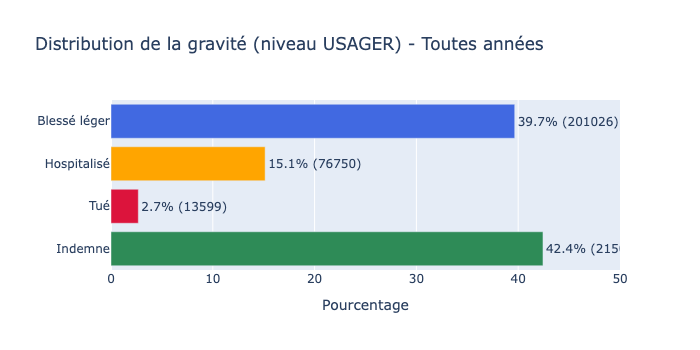


ATTENTION : Ces chiffres sont au niveau USAGER, pas au niveau ACCIDENT.
Un accident mortel peut avoir plusieurs usagers dont la plupart survivent.


In [12]:
# distribution de la gravité (niveau usager)
grav_labels = {1: 'Indemne', 2: 'Tué', 3: 'Hospitalisé', 4: 'Blessé léger'}
grav_colors = ['seagreen', 'crimson', 'orange', 'royalblue']

# calcul global
grav_global = []
for grav_code, grav_label in grav_labels.items():
    count = (all_usagers['grav'] == grav_code).sum()
    pct = count / len(all_usagers) * 100
    grav_global.append({
        'Gravité': grav_label,
        'Nombre': count,
        'Pourcentage': pct
    })

df_grav_global = pd.DataFrame(grav_global)

# barres horizontales
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=df_grav_global['Gravité'],
        x=df_grav_global['Pourcentage'],
        orientation='h',
        marker_color=grav_colors,
        text=df_grav_global.apply(lambda r: f"{r['Pourcentage']:.1f}% ({int(r['Nombre'])})", axis=1),
        textposition='outside'
    )
)

fig.update_layout(
    title_text="Distribution de la gravité (niveau USAGER) - Toutes années",
    xaxis_title="Pourcentage",
    yaxis_title="",
    height=350,
    xaxis=dict(range=[0, 50])
)

fig.show()

print("\nATTENTION : Ces chiffres sont au niveau USAGER, pas au niveau ACCIDENT.")
print("Un accident mortel peut avoir plusieurs usagers dont la plupart survivent.")

In [13]:
# comparaison niveau usager vs niveau accident
n_usagers_tues = (all_usagers['grav'] == 2).sum()
n_usagers_total = len(all_usagers)
pct_usagers_tues = n_usagers_tues / n_usagers_total * 100

print("Niveau USAGER :")
print(f"  Tués : {n_usagers_tues} ({pct_usagers_tues:.1f}%)")

# niveau accident : mortel si au moins 1 usager tué
accidents_mortels = all_usagers.groupby('Num_Acc')['grav'].apply(lambda x: (x == 2).any())
n_accidents_mortels = accidents_mortels.sum()
n_accidents_total = len(accidents_mortels)
pct_accidents_mortels = n_accidents_mortels / n_accidents_total * 100

print("\nNiveau ACCIDENT :")
print(f"  Accidents mortels : {n_accidents_mortels} ({pct_accidents_mortels:.1f}%)")

print(f"\n=> {pct_usagers_tues:.1f}% des usagers sont tués vs {pct_accidents_mortels:.1f}% des accidents sont mortels")
print("   (un accident mortel peut impliquer plusieurs survivants)")

Niveau USAGER :
  Tués : 13599 (2.7%)

Niveau ACCIDENT :
  Accidents mortels : 12798 (5.8%)

=> 2.7% des usagers sont tués vs 5.8% des accidents sont mortels
   (un accident mortel peut impliquer plusieurs survivants)


### 5.1 Définition des targets possibles

Nous définissons deux variables cibles au niveau accident :

| Target | Définition | Taux | Ratio |
|--------|------------|------|-------|
| mortel | Au moins 1 tué (grav=2) | ~5.8% | 1:16 |
| grave | Au moins 1 tué ou hospitalisé (grav ∈ {2,3}) | ~35.7% | 1:1.8 |

Observations clés :
- grave inclut mortel (100% des accidents mortels sont aussi graves)
- grave a 6× plus de cas positifs → meilleur apprentissage
- grave a un ratio de déséquilibre beaucoup plus faible

Choix de la target par use case : à décider dans les notebooks 04a/05a en fonction des contraintes opérationnelles.

In [14]:
def calculer_targets(usagers_df):
    # agrège la gravité au niveau accident
    targets = usagers_df.groupby('Num_Acc').agg(
        grav_max=('grav', 'min'),
        grav_list=('grav', list)
    ).reset_index()
    
    # mortel = au moins un tué (grav=2)
    targets['mortel'] = targets['grav_list'].apply(lambda x: 1 if 2 in x else 0)
    
    # grave = au moins un tué ou hospitalisé (grav in {2, 3})
    targets['grave'] = targets['grav_list'].apply(lambda x: 1 if (2 in x or 3 in x) else 0)
    
    return targets[['Num_Acc', 'mortel', 'grave']]

# calculer pour toutes les années
targets_par_annee = []
for annee in ANNEES:
    usagers = donnees_par_annee[annee]['usagers']
    targets = calculer_targets(usagers)
    targets['annee'] = annee
    targets_par_annee.append(targets)

all_targets = pd.concat(targets_par_annee, ignore_index=True)

print(f"Targets calculées pour {len(all_targets)} accidents")

Targets calculées pour 221044 accidents


In [15]:
# taux de mortalité et gravité par année
taux_par_annee = []

for annee in ANNEES:
    targets_annee = all_targets[all_targets['annee'] == annee]
    n_accidents = len(targets_annee)
    n_mortels = targets_annee['mortel'].sum()
    n_graves = targets_annee['grave'].sum()
    
    taux_par_annee.append({
        'Année': annee,
        'Accidents': n_accidents,
        'Mortels': n_mortels,
        'Graves': n_graves,
        'Taux mortel': n_mortels / n_accidents * 100,
        'Taux grave': n_graves / n_accidents * 100
    })

df_taux = pd.DataFrame(taux_par_annee)

print("Taux par année (niveau accident)")
print("---")
for _, row in df_taux.iterrows():
    print(f"  {int(row['Année'])} : {int(row['Accidents'])} accidents, "
          f"{int(row['Mortels'])} mortels ({row['Taux mortel']:.1f}%), "
          f"{int(row['Graves'])} graves ({row['Taux grave']:.1f}%)")

Taux par année (niveau accident)
---
  2021 : 56518 accidents, 3032 mortels (5.4%), 19553 graves (34.6%)
  2022 : 55302 accidents, 3337 mortels (6.0%), 19911 graves (36.0%)
  2023 : 54822 accidents, 3203 mortels (5.8%), 19785 graves (36.1%)
  2024 : 54402 accidents, 3226 mortels (5.9%), 19658 graves (36.1%)


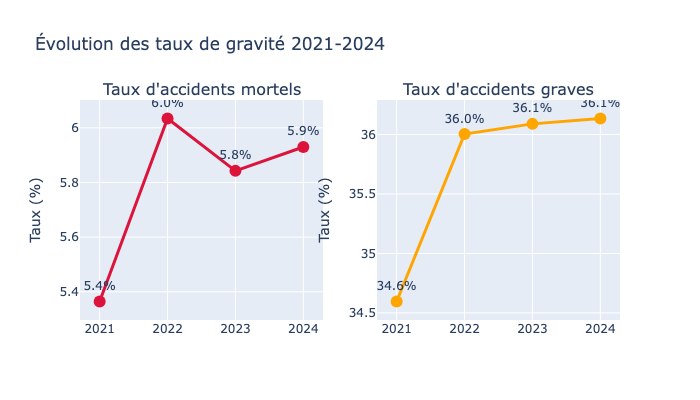

In [16]:
# evolution des taux
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Taux d\'accidents mortels', 'Taux d\'accidents graves')
)

fig.add_trace(
    go.Scatter(
        x=df_taux['Année'].astype(str),
        y=df_taux['Taux mortel'],
        mode='lines+markers+text',
        name='Mortel',
        line=dict(color='crimson', width=3),
        marker=dict(size=12),
        text=df_taux['Taux mortel'].apply(lambda x: f'{x:.1f}%'),
        textposition='top center'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_taux['Année'].astype(str),
        y=df_taux['Taux grave'],
        mode='lines+markers+text',
        name='Grave',
        line=dict(color='orange', width=3),
        marker=dict(size=12),
        text=df_taux['Taux grave'].apply(lambda x: f'{x:.1f}%'),
        textposition='top center'
    ),
    row=1, col=2
)

fig.update_yaxes(title_text='Taux (%)', row=1, col=1)
fig.update_yaxes(title_text='Taux (%)', row=1, col=2)

fig.update_layout(
    title_text='Évolution des taux de gravité 2021-2024',
    showlegend=False,
    height=400
)

fig.show()

### Observations sur les taux de gravité

- Taux mortel : ~5.5-6% - relativement stable sur 4 ans
- Taux grave : ~35-37% - également stable
- Pas de tendance marquée à la hausse ou à la baisse

Constat clé : Les data sont cohérentes entre années, ce qui valide la fusion.

### 5.2 Analyse du déséquilibre des classes

In [17]:
# analyse du déséquilibre
n_total = len(all_targets)
n_mortel = all_targets['mortel'].sum()
n_grave = all_targets['grave'].sum()

ratio_mortel = (n_total - n_mortel) / n_mortel
ratio_grave = (n_total - n_grave) / n_grave

print("Déséquilibre des classes")

print("\nTarget MORTEL :")
print(f"  Accidents mortels     : {n_mortel} ({n_mortel/n_total*100:.1f}%)")
print(f"  Accidents non-mortels : {n_total - n_mortel} ({(n_total-n_mortel)/n_total*100:.1f}%)")
print(f"  Ratio : 1:{ratio_mortel:.0f}")

print("\nTarget GRAVE :")
print(f"  Accidents graves      : {n_grave} ({n_grave/n_total*100:.1f}%)")
print(f"  Accidents non-graves  : {n_total - n_grave} ({(n_total-n_grave)/n_total*100:.1f}%)")
print(f"  Ratio : 1:{ratio_grave:.1f}")

Déséquilibre des classes

Target MORTEL :
  Accidents mortels     : 12798 (5.8%)
  Accidents non-mortels : 208246 (94.2%)
  Ratio : 1:16

Target GRAVE :
  Accidents graves      : 78907 (35.7%)
  Accidents non-graves  : 142137 (64.3%)
  Ratio : 1:1.8


### Point clé : Implications du déséquilibre selon la target choisie

Le déséquilibre des classes a des implications différentes selon la target :

Si on choisit mortel (ratio 1:16) :
- Un modèle naïf prédisant toujours "non mortel" aurait 94% accuracy... mais 0% recall !
- Déséquilibre fort → SMOTE probablement nécessaire
- Mais... un accident mortel = décès souvent instantané, l'intervention ne change pas grand-chose

Si on choisit grave (ratio 1:1.8) :
- Déséquilibre modéré, gérable avec class_weight='balanced'
- Plus de cas positifs pour apprendre (78k vs 12k)
- Un accident grave (hospitalisé) = l'intervention rapide peut faire la différence

Réflexion métier :
- 100% des accidents mortels sont inclus dans les accidents graves
- Pour les secours, détecter un accident "grave" (qui peut devenir mortel sans intervention) est plus utile que détecter un accident déjà mortel

→ Cette décision sera prise dans le notebook 04a/05a après analyse complète

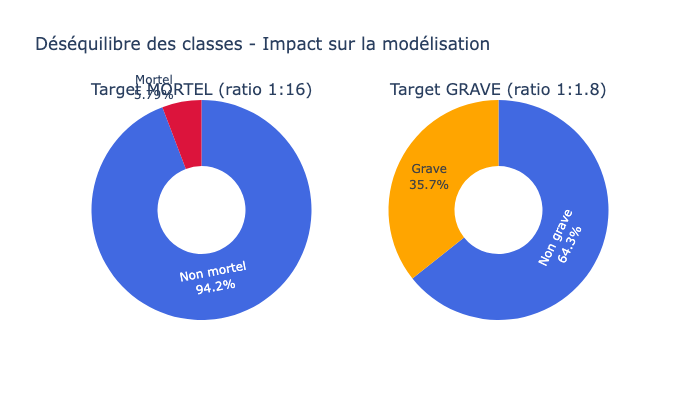

In [18]:
# visualisation du déséquilibre
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f'Target MORTEL (ratio 1:{ratio_mortel:.0f})',
        f'Target GRAVE (ratio 1:{ratio_grave:.1f})'
    ),
    specs=[[{"type": "pie"}, {"type": "pie"}]]
)

fig.add_trace(
    go.Pie(
        labels=['Non mortel', 'Mortel'],
        values=[n_total - n_mortel, n_mortel],
        marker_colors=['royalblue', 'crimson'],
        textinfo='label+percent',
        hole=0.4
    ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(
        labels=['Non grave', 'Grave'],
        values=[n_total - n_grave, n_grave],
        marker_colors=['royalblue', 'orange'],
        textinfo='label+percent',
        hole=0.4
    ),
    row=1, col=2
)

fig.update_layout(
    title_text='Déséquilibre des classes - Impact sur la modélisation',
    height=400,
    showlegend=False
)

fig.show()

### Choix de la cible : `grave` plutôt que `mortel`

Deux cibles possibles :
- **mortel** (décès) : ratio ~1:16, trop déséquilibré, peu d'accidents mortels
- **grave** (hospitalisation ou décès) : ratio ~1:1.8, plus exploitable

On retient `grave` car :
- Le déséquilibre est gérable (pas besoin de techniques extrêmes de rééquilibrage)
- C'est plus utile opérationnellement : un accident grave nécessite des moyens renforcés (SMUR, hélicoptère), que la victime décède ou soit hospitalisée

---

## 6. Vérification de la cohérence des colonnes entre années

Avant de fusionner les 4 années, vérifions que les colonnes sont identiques pour chaque table.

In [19]:
# comparer les colonnes entre années
for table_name in ['caract', 'lieux', 'usagers', 'vehicules']:
    print(f"\n{table_name.upper()}")
    
    cols_par_annee = {}
    for annee in ANNEES:
        cols = set(donnees_par_annee[annee][table_name].columns) - {'annee'}
        cols_par_annee[annee] = cols
    
    cols_communes = cols_par_annee[2021]
    for annee in ANNEES[1:]:
        cols_communes = cols_communes & cols_par_annee[annee]
    
    for annee in ANNEES:
        cols_specifiques = cols_par_annee[annee] - cols_communes
        if cols_specifiques:
            print(f"  {annee} colonnes spécifiques : {cols_specifiques}")
    
    print(f"  Colonnes communes : {len(cols_communes)}")


CARACT
  Colonnes communes : 15

LIEUX
  Colonnes communes : 18

USAGERS
  Colonnes communes : 16

VEHICULES
  Colonnes communes : 11


### Observation : Colonnes identiques entre années

Toutes les tables ont exactement les mêmes colonnes sur les 4 années (après renommage Accident_Id → Num_Acc pour 2022).

Conclusion : La fusion des 4 années peut se faire par simple concaténation (pd.concat) sans risque de colonnes manquantes ou incompatibles.

---

## 7. Analyse des valeurs manquantes et codes spéciaux

Les data BAAC utilisent des codes spéciaux pour les valeurs manquantes ou non renseignées :
- -1 = Non renseigné (fréquent)
- 9 = Autre/Non renseigné (selon les variables)
- 0 = Parfois utilisé pour "non applicable"

In [20]:
# valeurs manquantes et codes spéciaux
print("VALEURS MANQUANTES ET CODES SPÉCIAUX (4 ANNÉES)")
print("---")

for table_name in ['caract', 'lieux', 'usagers', 'vehicules']:
    all_table = pd.concat(
        [donnees_par_annee[a][table_name] for a in ANNEES], 
        ignore_index=True
    )
    
    print(f"\n{table_name.upper()} ({len(all_table)} lignes)")
    
    has_issue = False
    for col in all_table.columns:
        if col in ['Num_Acc', 'annee', 'adr', 'com', 'dep', 'voie', 'v1', 'v2']:
            continue
        
        n_null = all_table[col].isna().sum()
        n_moins1 = 0
        if all_table[col].dtype in ['int64', 'float64']:
            n_moins1 = (all_table[col] == -1).sum()
        
        if n_null > 0 or n_moins1 > 0:
            has_issue = True
            pct_null = n_null / len(all_table) * 100
            pct_m1 = n_moins1 / len(all_table) * 100
            parts = []
            if n_null > 0:
                parts.append(f"{n_null} NaN ({pct_null:.1f}%)")
            if n_moins1 > 0:
                parts.append(f"{n_moins1} valeurs -1 ({pct_m1:.1f}%)")
            print(f"  {col} : {' | '.join(parts)}")
    
    if not has_issue:
        print("  Aucune valeur manquante ou code -1")

VALEURS MANQUANTES ET CODES SPÉCIAUX (4 ANNÉES)
---

CARACT (221044 lignes)
  lum : 4 valeurs -1 (0.0%)
  int : 13 valeurs -1 (0.0%)
  atm : 13 valeurs -1 (0.0%)
  col : 102 valeurs -1 (0.0%)

LIEUX (252928 lignes)
  circ : 15773 valeurs -1 (6.2%)
  vosp : 8160 valeurs -1 (3.2%)
  prof : 280 valeurs -1 (0.1%)
  plan : 220 valeurs -1 (0.1%)
  lartpc : 252728 NaN (99.9%)
  surf : 269 valeurs -1 (0.1%)
  infra : 3048 valeurs -1 (1.2%)
  situ : 251 valeurs -1 (0.1%)
  vma : 9980 valeurs -1 (3.9%)

USAGERS (506886 lignes)
  place : 30 valeurs -1 (0.0%)
  grav : 419 valeurs -1 (0.1%)
  sexe : 10632 valeurs -1 (2.1%)
  an_nais : 11118 NaN (2.2%)
  trajet : 11269 valeurs -1 (2.2%)
  secu1 : 9865 valeurs -1 (1.9%)
  secu2 : 223921 valeurs -1 (44.2%)
  secu3 : 489711 valeurs -1 (96.6%)
  locp : 240813 valeurs -1 (47.5%)
  etatp : 467713 valeurs -1 (92.3%)

VEHICULES (378071 lignes)
  senc : 865 valeurs -1 (0.2%)
  catv : 12 valeurs -1 (0.0%)
  obs : 176 valeurs -1 (0.0%)
  obsm : 162 valeurs -1 

### Observation : Qualité des data par table

CARACT : Excellente qualité. Seulement 102 valeurs -1 sur 221k lignes pour col (0.05%). Les autres colonnes sont quasi-complètes.

LIEUX : Qualité variable.
- lartpc (largeur terre-plein central) = 99.9% NaN → colonne inutilisable, à supprimer
- circ (circulation) = 6.2% de -1, vma = 3.9% de -1 → à traiter (imputation ou catégorie "inconnu")
- Les autres colonnes sont correctes (< 0.2% de -1)

USAGERS : Attention aux équipements de sécurité.
- secu2 = 44.2% de -1, secu3 = 96.6% de -1 → normal (la plupart des usagers n'ont qu'un seul équipement)
- locp (localisation piéton) = 47.5%, etatp (état piéton) = 92.3% → normal (non applicable aux non-piétons)
- grav (la target) a 419 valeurs -1 (0.1%) → à exclure
- an_nais = 2.2% NaN, sexe = 2.1% de -1 → imputation nécessaire

VEHICULES : occutc (occupation transport en commun) = 99.1% NaN → inutilisable, à supprimer. Le reste est propre.

Colonnes à supprimer : lartpc (LIEUX), occutc (VEHICULES) — quasi entièrement vides.

In [21]:
# analyser les GPS invalides
all_caract['lat_num'] = pd.to_numeric(
    all_caract['lat'].astype(str).str.replace(',', '.'), 
    errors='coerce'
)
all_caract['long_num'] = pd.to_numeric(
    all_caract['long'].astype(str).str.replace(',', '.'), 
    errors='coerce'
)

# GPS France métropolitaine : lat entre 41 et 51, long entre -5 et 10
gps_valides = (
    (all_caract['lat_num'] >= 41) & (all_caract['lat_num'] <= 51) &
    (all_caract['long_num'] >= -5) & (all_caract['long_num'] <= 10)
)

n_total_gps = len(all_caract)
n_valides = gps_valides.sum()
n_invalides = n_total_gps - n_valides

print(f"Analyse des coordata GPS ({n_total_gps} accidents)")
print(f"  GPS valides (France métro) : {n_valides} ({n_valides/n_total_gps*100:.1f}%)")
print(f"  GPS invalides              : {n_invalides} ({n_invalides/n_total_gps*100:.1f}%)")

# détail par année
print("\nDétail par année :")
for annee in ANNEES:
    caract_a = donnees_par_annee[annee]['caract'].copy()
    caract_a['lat_num'] = pd.to_numeric(caract_a['lat'].astype(str).str.replace(',', '.'), errors='coerce')
    caract_a['long_num'] = pd.to_numeric(caract_a['long'].astype(str).str.replace(',', '.'), errors='coerce')
    gps_ok = ((caract_a['lat_num'] >= 41) & (caract_a['lat_num'] <= 51) &
              (caract_a['long_num'] >= -5) & (caract_a['long_num'] <= 10))
    n_inv = len(caract_a) - gps_ok.sum()
    pct_inv = n_inv / len(caract_a) * 100
    print(f"  {annee} : {n_inv} invalides ({pct_inv:.1f}%)")

print(f"\n=> {n_invalides} accidents hors métropole ou GPS manquant, à filtrer")

Analyse des coordonnées GPS (221044 accidents)
  GPS valides (France métro) : 208454 (94.3%)
  GPS invalides              : 12590 (5.7%)

Détail par année :
  2021 : 3012 invalides (5.3%)
  2022 : 2956 invalides (5.3%)
  2023 : 3228 invalides (5.9%)
  2024 : 3394 invalides (6.2%)

=> 12590 accidents hors métropole ou GPS manquant, à filtrer


### Observation : Filtrage géographique nécessaire

Les 12,590 accidents avec GPS invalide (5.7%) correspondent principalement à :
- DOM-TOM : Guadeloupe, Martinique, Réunion, Guyane, Mayotte
- GPS manquants : Coordata nulles ou mal formatées

Décision : Filtrer ces accidents pour se concentrer sur la France métropolitaine.

Justification :
- Les conditions de circulation DOM-TOM sont très différentes (infrastructure, climat)
- Mélanger les deux populations risquerait de bruiter le modèle
- ~208k accidents restent largement suffisants pour l'entraînement

---
## Récapitulatif

| Décision | Choix | Justification |
|----------|-------|---------------|
| Cible | `grave` (hospit. ou décès) | Ratio 1:1.8 exploitable, pertinent pour les secours |
| Périmètre | France métropolitaine, 2021-2024 | 4 ans de data, ~52 000 accidents/an |
| Tables utiles | caractéristiques, lieux, véhicules | La table usagers est exploitée via des agrégats |

**Prochaine étape** → `02a_preparation_complete.ipynb` : fusion des 4 années et nettoyage des data.

In [22]:
# résumé
print("RÉSUMÉ - Exploration BAAC 2021-2024")
print("---")
print(f"{len(all_caract)} accidents sur 4 ans, ~{len(all_caract)//4} par an")
print(f"{len(all_usagers)} usagers impliqués")
print(f"Taux mortel : {all_targets['mortel'].mean()*100:.1f}% (ratio 1:{ratio_mortel:.0f})")
print(f"Taux grave  : {all_targets['grave'].mean()*100:.1f}% (ratio 1:{ratio_grave:.1f})")
print(f"{pct_multi:.0f}% des accidents ont plusieurs lieux (intersections)")
print(f"{n_invalides} accidents hors métropole à filtrer ({n_invalides/len(all_caract)*100:.1f}%)")
print("Données cohérentes entre années, taux stables")

RÉSUMÉ - Exploration BAAC 2021-2024
---
221044 accidents sur 4 ans, ~55261 par an
506886 usagers impliqués
Taux mortel : 5.8% (ratio 1:16)
Taux grave  : 35.7% (ratio 1:1.8)
14% des accidents ont plusieurs lieux (intersections)
12590 accidents hors métropole à filtrer (5.7%)
Données cohérentes entre années, taux stables
